[View in Colaboratory](https://colab.research.google.com/github/hschoi1/rich_latent/blob/master/NFs.ipynb)

In [13]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

/usr/local/lib/python3.6/dist-packages/google/colab/auth.py:133: ResourceWarning: unclosed <ssl.SSLSocket fd=73, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 58654), raddr=('74.125.141.84', 443)>
  if _check_adc():


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!python setup.py build

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import itertools
import pdb
from sklearn.utils import shuffle
from sklearn.metrics import average_precision_score, roc_auc_score
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tf.logging.set_verbosity(tf.logging.INFO)
tf.set_random_seed(0)

In [51]:

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/MNIST_data/", one_hot=False)

train_data = mnist.train.images.astype(float)
train_labels = mnist.train.labels.astype(float)
from sklearn.utils import shuffle
train_data, train_labels = shuffle(train_data, train_labels, random_state=0)
numbers = []
for i in range(10):
    numbers.append(train_data[train_labels==i, :])

test_data = train_data[-100:]
test_labels = train_labels[-100:]

train_data = train_data[:-100]
train_labels = train_labels[:-100]

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./data/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
def make_encoder(x, z_size=2):
    x = tf.cast(x, dtype=tf.float32)
    net = make_enc_nn(x, z_size * 2)
    #return tfd.MultivariateNormalDiag(loc=net[..., :z_size], scale_diag=tf.nn.softplus(net[..., z_size:]))
    return net[..., :z_size], tf.nn.softplus(net[..., z_size:])



def make_prior(z_size=2):
    return make_arflow(tfd.MultivariateNormalDiag(loc=tf.zeros([z_size], dtype=tf.float32), scale_diag = tf.ones([z_size], dtype=tf.float32)))


def mean_var(results):
    results = tf.cast(results, dtype=tf.float32)
    predictive_mean, predictive_variance = tf.nn.moments(results, axes=[0])
    return predictive_mean, predictive_variance


# not yet used
# for collecting mean and var to compute ensemble mean and var
def ensemble_mean_var(ensemble_results):
    M = len(ensemble_results)
    final_mean = 0
    final_var = 0
    for i in range(M):
        mean, var = ensemble_results[i]
        final_mean += mean / M
        final_var += (var + np.square(mean))/ M
    final_var -= np.square(final_mean)
    return final_mean, final_var


# log p(x|zk) specified by the paper
def loss_fct(mean, var, labels):
    loss = 0
    loss += tf.log(var) / 2
    loss += tf.square(labels - mean) / (2 * var)
    return loss


def get_batch(data_x, batch_size=100):
    batch_n = len(data_x) // batch_size
    for i in range(batch_n):
        batch_x = data_x[i * batch_size:(i + 1) * batch_size]
        yield batch_x


model 0 epoch 0
loss at 0 : 543.50995         elbo1: 2.8438241   elbo2: 543.2301   elbo3: -2.5639808
loss at 400 : 208.97244         elbo1: 4.607685   elbo2: 207.27863   elbo3: -2.9138803
model 0 epoch 1
loss at 800 : 191.77362         elbo1: 4.2659926   elbo2: 188.81027   elbo3: -1.3026814
model 0 epoch 2
loss at 1200 : 191.80139         elbo1: 4.3203874   elbo2: 188.42146   elbo3: -0.94045526
loss at 1600 : 182.46684         elbo1: 4.478838   elbo2: 178.75356   elbo3: -0.76552904
model 0 epoch 3
loss at 2000 : 175.52267         elbo1: 4.6737967   elbo2: 171.42418   elbo3: -0.5752843
model 0 epoch 4
loss at 2400 : 175.24738         elbo1: 4.4956427   elbo2: 171.21863   elbo3: -0.4669019
model 0 epoch 5
loss at 2800 : 166.24377         elbo1: 4.722992   elbo2: 162.0019   elbo3: -0.48112723
loss at 3200 : 165.27614         elbo1: 5.0965014   elbo2: 160.68065   elbo3: -0.5010066
model 0 epoch 6
loss at 3600 : 165.34488         elbo1: 4.8918743   elbo2: 160.89572   elbo3: -0.4427012
model

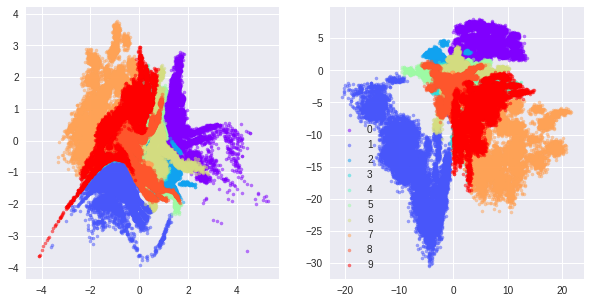

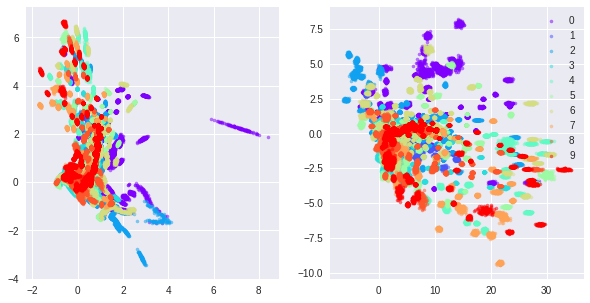

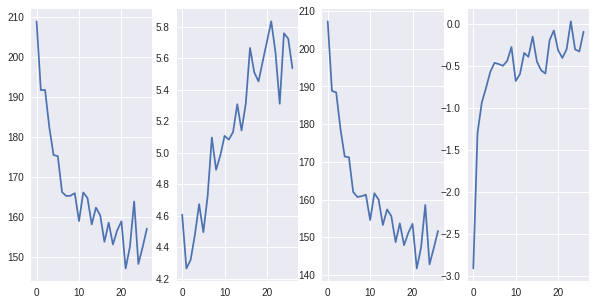

model 1 epoch 0
loss at 0 : 543.8396         elbo1: 2.6161323   elbo2: 543.62573   elbo3: -2.4022036
loss at 400 : 201.7618         elbo1: 4.4572096   elbo2: 200.02419   elbo3: -2.7195997
model 1 epoch 1
loss at 800 : 198.85907         elbo1: 3.7484617   elbo2: 196.63121   elbo3: -1.5205961
model 1 epoch 2
loss at 1200 : 193.9727         elbo1: 3.628237   elbo2: 191.30957   elbo3: -0.96511763
loss at 1600 : 190.36111         elbo1: 3.876081   elbo2: 187.40898   elbo3: -0.923957
model 1 epoch 3
loss at 2000 : 190.79803         elbo1: 4.0902553   elbo2: 187.26802   elbo3: -0.5602418
model 1 epoch 4
loss at 2400 : 177.10458         elbo1: 4.4288287   elbo2: 173.10098   elbo3: -0.4252032
model 1 epoch 5
loss at 2800 : 178.46101         elbo1: 4.379907   elbo2: 174.52615   elbo3: -0.4450289
loss at 3200 : 162.9197         elbo1: 4.814936   elbo2: 158.87059   elbo3: -0.76583517
model 1 epoch 6
loss at 3600 : 165.92943         elbo1: 4.9423456   elbo2: 161.47386   elbo3: -0.48678902
model 1 e

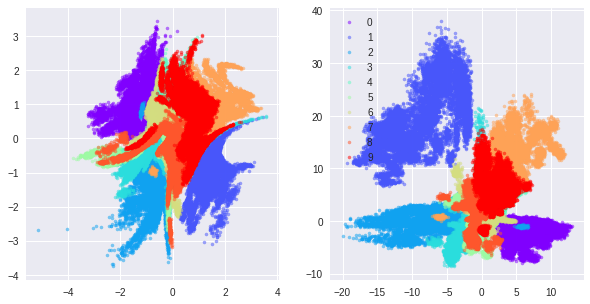

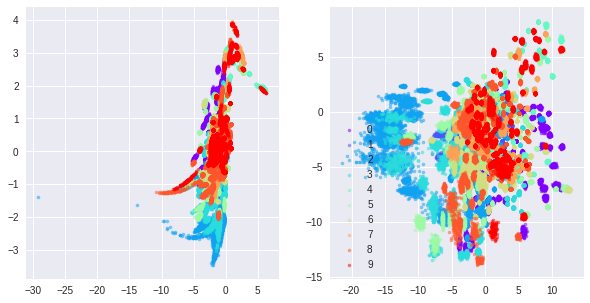

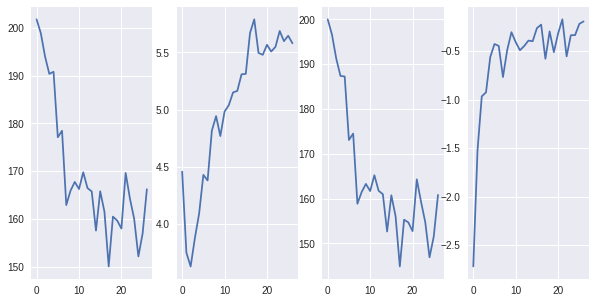

model 2 epoch 0
loss at 0 : 543.8243         elbo1: 2.3147225   elbo2: 543.4266   elbo3: -1.9169981
loss at 400 : 205.35553         elbo1: 3.723716   elbo2: 203.84592   elbo3: -2.214111
model 2 epoch 1
loss at 800 : 188.411         elbo1: 3.8991199   elbo2: 185.67654   elbo3: -1.1646578
model 2 epoch 2
loss at 1200 : 187.23813         elbo1: 3.8204942   elbo2: 184.22879   elbo3: -0.8111486
loss at 1600 : 180.22623         elbo1: 4.0306473   elbo2: 176.77762   elbo3: -0.5820263
model 2 epoch 3
loss at 2000 : 183.05713         elbo1: 4.0155067   elbo2: 179.5417   elbo3: -0.5000587
model 2 epoch 4
loss at 2400 : 174.8928         elbo1: 4.3711324   elbo2: 171.00558   elbo3: -0.4839008
model 2 epoch 5
loss at 2800 : 173.85516         elbo1: 4.711723   elbo2: 169.61908   elbo3: -0.47568643
loss at 3200 : 173.19545         elbo1: 4.8911757   elbo2: 168.74266   elbo3: -0.43838578
model 2 epoch 6
loss at 3600 : 176.47887         elbo1: 5.0004125   elbo2: 171.81223   elbo3: -0.3337458
model 2 ep

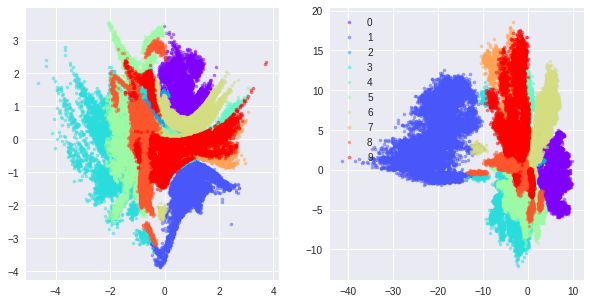

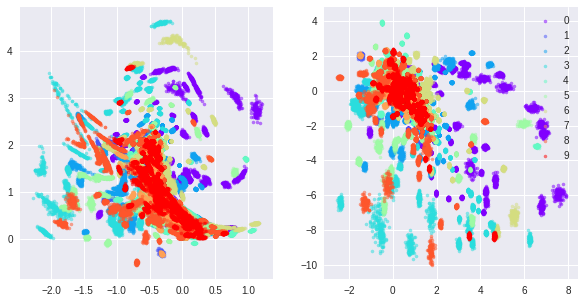

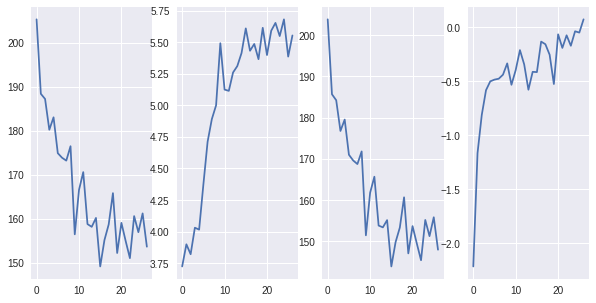

model 3 epoch 0
loss at 0 : 544.0095         elbo1: 2.4970217   elbo2: 543.732   elbo3: -2.219499
loss at 400 : 202.86514         elbo1: 4.406595   elbo2: 201.29483   elbo3: -2.8362765
model 3 epoch 1
loss at 800 : 192.49188         elbo1: 3.8043811   elbo2: 189.98502   elbo3: -1.2975452
model 3 epoch 2
loss at 1200 : 187.66411         elbo1: 4.1309752   elbo2: 184.92535   elbo3: -1.3922381
loss at 1600 : 191.08794         elbo1: 4.0777354   elbo2: 187.98712   elbo3: -0.97694474
model 3 epoch 3
loss at 2000 : 183.94218         elbo1: 4.3789244   elbo2: 180.37677   elbo3: -0.8135193
model 3 epoch 4
loss at 2400 : 179.52834         elbo1: 4.5364776   elbo2: 175.37154   elbo3: -0.3796982
model 3 epoch 5
loss at 2800 : 169.71025         elbo1: 4.545225   elbo2: 165.75372   elbo3: -0.5886997
loss at 3200 : 180.06606         elbo1: 4.5386925   elbo2: 176.0178   elbo3: -0.49045837
model 3 epoch 6
loss at 3600 : 172.06795         elbo1: 4.5375147   elbo2: 167.95305   elbo3: -0.4226035
model 3 

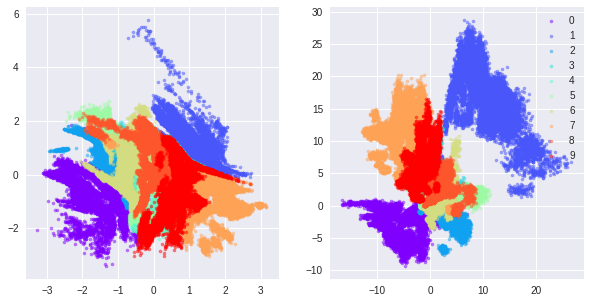

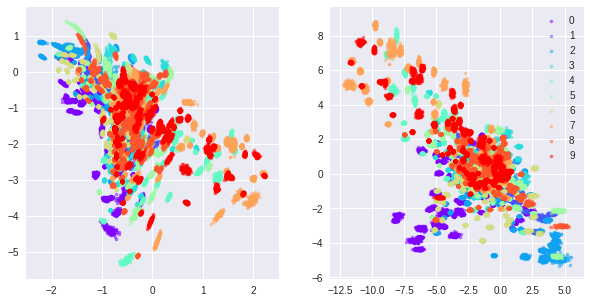

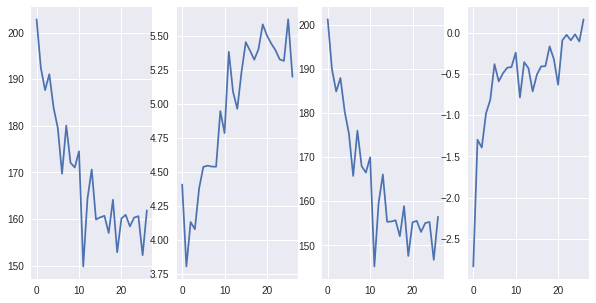

model 4 epoch 0
loss at 0 : 543.5593         elbo1: 2.2454407   elbo2: 543.19995   elbo3: -1.8860556
loss at 400 : 217.24728         elbo1: 5.262076   elbo2: 216.82358   elbo3: -4.8383493
model 4 epoch 1
loss at 800 : 189.13727         elbo1: 3.2693286   elbo2: 187.49391   elbo3: -1.6259489
model 4 epoch 2
loss at 1200 : 192.61505         elbo1: 3.0231977   elbo2: 189.98534   elbo3: -0.39346772
loss at 1600 : 179.7336         elbo1: 3.630348   elbo2: 176.05197   elbo3: 0.051287595
model 4 epoch 3
loss at 2000 : 179.87567         elbo1: 3.5401576   elbo2: 176.1241   elbo3: 0.211413
model 4 epoch 4
loss at 2400 : 177.38094         elbo1: 3.8156092   elbo2: 173.44164   elbo3: 0.12369639
model 4 epoch 5
loss at 2800 : 168.17696         elbo1: 4.330172   elbo2: 163.9906   elbo3: -0.14382364
loss at 3200 : 171.69035         elbo1: 4.210268   elbo2: 167.53804   elbo3: -0.05796317
model 4 epoch 6
loss at 3600 : 165.3226         elbo1: 4.623042   elbo2: 160.79947   elbo3: -0.099940166
model 4 e

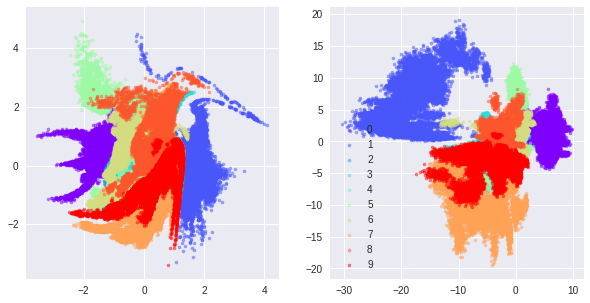

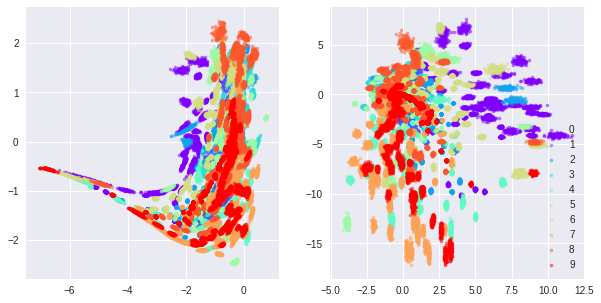

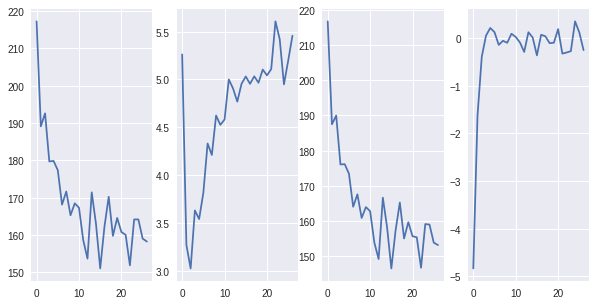

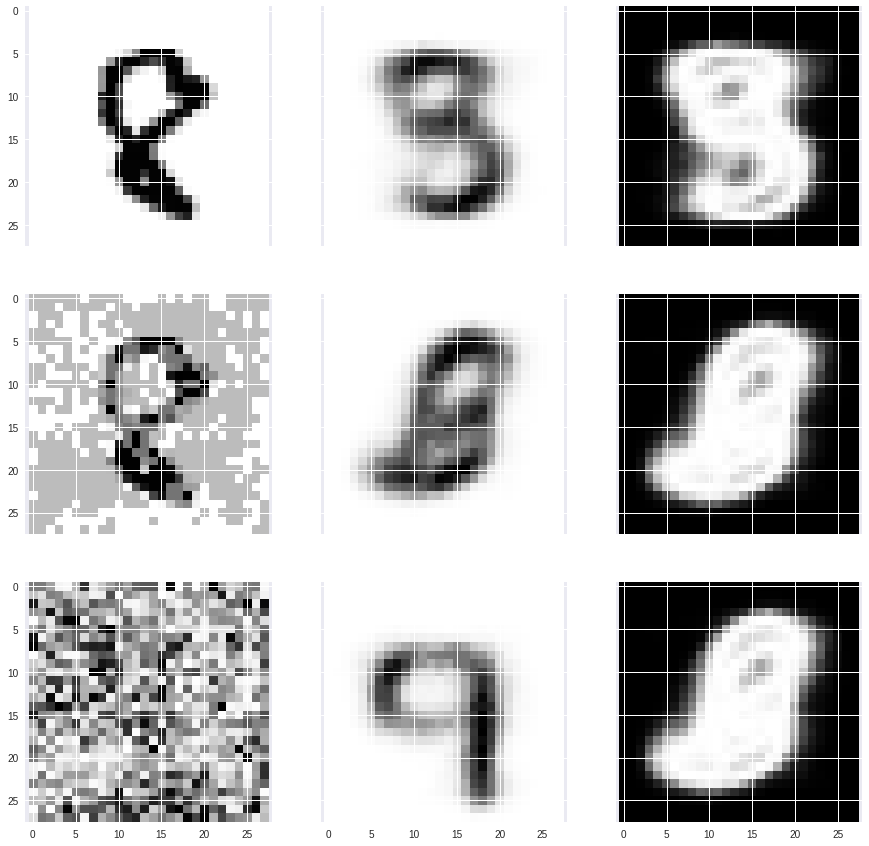

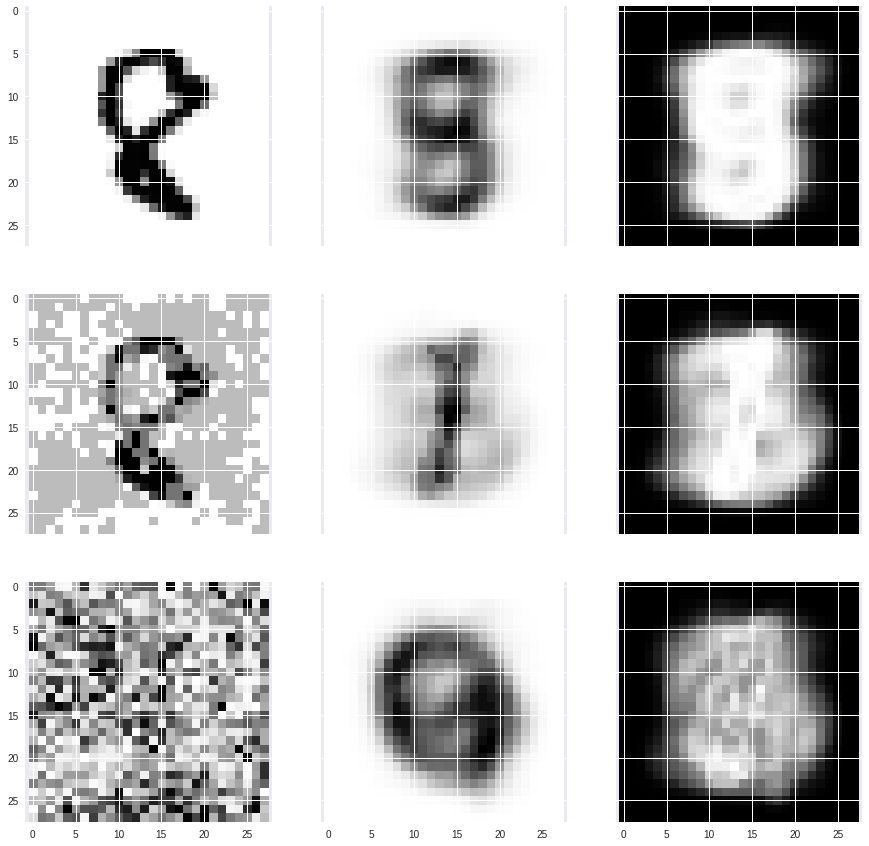

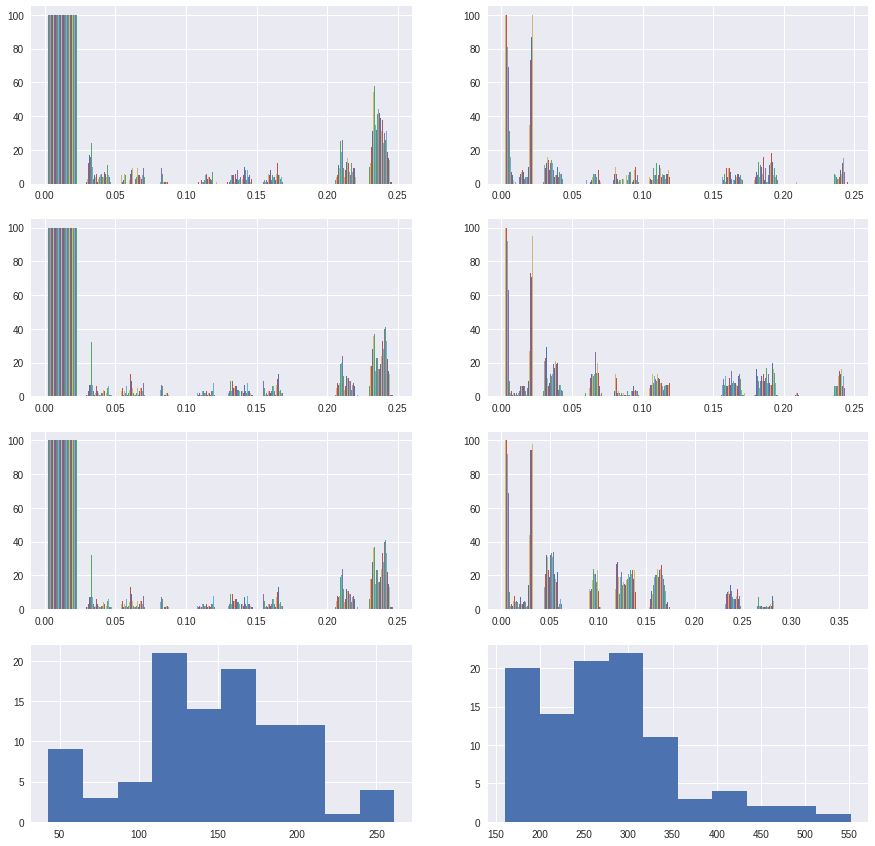

In [53]:



num_models = 5
ensemble_results = []
adv_ensemble_results = []
adv_ensemble_results2 = []
adv_elbo = []
adv_elbo2 = []

def make_encoder(x, z_size=2):  
    x = tf.cast(x, dtype=tf.float32)
    net = make_enc_nn(x, z_size * 2)
    #return tfd.MultivariateNormalDiag(loc=net[..., :z_size], scale_diag=tf.nn.softplus(net[..., z_size:]))
    return net[..., :z_size], tf.nn.softplus(net[..., z_size:])


def make_decoder(z, x_shape=784):
    net = make_dec_nn(z, x_shape)
    #mu_net = net[...,:x_shape]
    #sigma_net = net[...,x_shape:]
    return tfd.Independent(tfd.Bernoulli(logits=net))

def make_enc_nn(x, out_size, hidden_size=(128,128)):
    net = x
    for h in hidden_size:
        net = tf.layers.dense(inputs=net, units=h, activation=tf.nn.relu)
    return tf.layers.dense(inputs=net, units=out_size)


def make_dec_nn(x, out_size, hidden_size=(256,256,256)):
    net = x
    for h in hidden_size:
        net = tf.layers.dense(inputs=net, units=h, activation=tf.nn.relu)
    return tf.layers.dense(inputs=net, units=out_size)



def make_arflow(z_dist, n_flows=8, hidden_size=(512,) * 2, invert=False):
    chain = list(itertools.chain.from_iterable([tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_size)),
                                                   tfb.Permute(np.random.permutation(2)), ] for _ in range(n_flows)))
    return tfd.TransformedDistribution(distribution=z_dist, bijector=tfb.Chain(chain[:-1]))

def make_prior(z_size=2):
    return make_arflow(tfd.MultivariateNormalDiag(loc=tf.zeros([z_size], dtype=tf.float32), scale_diag = tf.ones([z_size], dtype=tf.float32)))


# replicate paper

# check if it really works


tf.reset_default_graph()
with tf.Graph().as_default() as g:
    input_layer = tf.placeholder(tf.float32, shape=[None, 784], name='x')
    output_layer = tf.placeholder(tf.float32, shape=[None, 784], name='x')
    
    
    latent = make_prior()

    # sample z0
    with tf.variable_scope("encoder"):
      enc_mean, enc_std = make_encoder(input_layer)
    enc = tfd.MultivariateNormalDiag(loc=enc_mean, scale_diag=enc_std)
    enc_samples = enc.sample()
    
    
    posterior_samples = enc.sample(100)
    samples = [latent.bijector.inverse(posterior_samples)]
    samples.append(posterior_samples)
    
    '''
    #my_samples = enc.sample(100)
    latent_samples = latent.sample(100)
    samples = [latent_samples]
    
    # construct IAF flows
    
    z_tmp = latent.bijector.inverse(latent_samples)
    samples = [z_tmp]

    names = [enc.name]
    names = [latent.name]
    # transform back to the prior
#     for bijector in latent.bijector.bijectors:
#         latent_samples = bijector.inverse(latent_samples)
#         samples.append(latent_samples) 
        
#     samples = samples[::-1]
    for bijector in reversed(latent.bijector.bijectors):
         z_tmp = bijector.forward(z_tmp)
         samples.append(z_tmp)
         names.append(bijector.name)
    # import pdb; pdb.set_trace()
    '''
    # reconstruct input

    with tf.variable_scope("decoder"):
      recons = make_decoder(enc_samples)

    recons_mean = recons.mean()
    recons_var = recons.variance()
   
  
    # elbo2  is reconstruction loss
    # elbo1+elbo3 is "kl divergence"
    
    
    elbo1_list = -latent.log_prob(enc_samples)
    elbo1 = tf.reduce_mean(elbo1_list)
    elbo2_list = -recons.log_prob(output_layer)
    elbo2 = tf.reduce_mean(elbo2_list)
    elbo3_list = enc.log_prob(enc_samples)
    elbo3 = tf.reduce_mean(elbo3_list)
    elbo_list = elbo1_list+elbo2_list+elbo3_list
    elbo = tf.reduce_mean(elbo_list)
    
    gradients = tf.gradients(elbo, input_layer)
    adv_examples = input_layer + 0.3*tf.sign(gradients)[0]
    
    
    random_noise = tfd.Uniform(low=0.0, high=1.0)
    random_noise_samples = random_noise.sample(sample_shape=(100,784))
    adv_examples2 = random_noise_samples - 0.3*tf.sign(gradients)[0]
    
    #adv_examples = input_layer 
    
    with tf.variable_scope("encoder", reuse=True):
      adv_enc_mean, adv_enc_std = make_encoder(adv_examples)
    with tf.variable_scope("encoder", reuse=True):  
      adv_enc_mean2, adv_enc_std2 = make_encoder(adv_examples2)
      
    adv_enc = tfd.MultivariateNormalDiag(loc=adv_enc_mean, scale_diag=adv_enc_std)
    adv_enc2 = tfd.MultivariateNormalDiag(loc=adv_enc_mean2, scale_diag=adv_enc_std2)

    adv_enc_samples = adv_enc.sample()
    adv_enc_samples2 = adv_enc2.sample()
    
    adv_posterior_samples = adv_enc.sample(100)
    adv_posterior_samples2 = adv_enc2.sample(100)
    adv_samples = [latent.bijector.inverse(adv_posterior_samples)]
    adv_samples2 = [latent.bijector.inverse(adv_posterior_samples2)]

    adv_samples.append(adv_posterior_samples)
    adv_samples2.append(adv_posterior_samples2)
    
    with tf.variable_scope("decoder", reuse=True):
      adv_recons = make_decoder(adv_enc_samples)
    with tf.variable_scope("decoder", reuse=True):
      adv_recons2 = make_decoder(adv_enc_samples2)

    adv_recons_mean = adv_recons.mean()
    adv_recons_mean2 = adv_recons2.mean()
    adv_recons_var = adv_recons.variance()
    adv_recons_var2 = adv_recons.variance()
    
    adv_elbo1_list = - latent.log_prob(adv_enc_samples)
    adv_elbo1 = tf.reduce_mean(adv_elbo1_list)
    adv_elbo2_list = - adv_recons.log_prob(output_layer)
    adv_elbo2 = tf.reduce_mean(adv_elbo2_list)
    adv_elbo3_list = adv_enc.log_prob(adv_enc_samples)
    adv_elbo3 = tf.reduce_mean(adv_elbo3_list)
    adv_elbo_list = adv_elbo1_list + adv_elbo2_list + adv_elbo3_list
    adv_elbo = adv_elbo1 + adv_elbo2 + adv_elbo3
    
    adv_elbo1_list2 = - latent.log_prob(adv_enc_samples2)
    adv_elbo12 = tf.reduce_mean(adv_elbo1_list2)
    adv_elbo2_list2 = - adv_recons2.log_prob(output_layer)
    adv_elbo22 = tf.reduce_mean(adv_elbo2_list2)
    adv_elbo3_list2 = adv_enc2.log_prob(adv_enc_samples2)
    adv_elbo32 = tf.reduce_mean(adv_elbo3_list2)
    adv_elbo_list2 = adv_elbo1_list2 + adv_elbo2_list2 + adv_elbo3_list2
    adv_elbo2 = adv_elbo12 + adv_elbo22 + adv_elbo32
    
    optimizer = tf.train.AdamOptimizer(0.0001)
    train_op = optimizer.minimize(elbo)
    #f_train_op = optimizer.minimize(elbo, var_list=flows_variables+decoder_variables)


    tf.summary.scalar('loss', elbo)
    summ_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./logs/train')
    saver = tf.train.Saver()
    init = tf.global_variables_initializer()
    g.finalize()

# train and visualize
with tf.Session(graph=g) as sess:
   
    train_writer.add_graph(g)
    
    for model in range(num_models):
        step = 0
        losses = []
        losses_1 = []
        losses_2 = []
        losses_3 = []
        global_step = []
        sess.run(init)
        
        for epoch in range(20):
        
            train_data = shuffle(train_data, random_state=0)
            print("model",str(model),"epoch",str(epoch))

            for batch_x in get_batch(train_data, 100):
                # train
                feed_dict = {input_layer: batch_x, output_layer:batch_x}
                #if step <= 5000:
                fetch_dict = {'loss': elbo, 'elbo1': elbo1, 'elbo2': elbo2, 'elbo3': elbo3, 'train': train_op, 'summary': summ_op}
                #else:
                #    fetch_dict = {'loss': elbo, 'elbo1': elbo1, 'elbo2': elbo2, 'elbo3': elbo3, 'train': f_train_op, 'summary': summ_op}
                result = sess.run(fetch_dict, feed_dict)
                # collect loss
                if step % 400 == 0:
                    train_writer.add_summary(result['summary'], step)
                    global_step.append(step)
                    losses.append(result['loss'])
                    losses_1.append(result['elbo1'])
                    losses_2.append(result['elbo2'])
                    losses_3.append(result['elbo3'])
                    print("loss at", step, ":", result['loss'], "        elbo1:", result["elbo1"], "  elbo2:", result["elbo2"], "  elbo3:", result["elbo3"])

                step += 1      

        # testing
          
        #f, arr = plt.subplots(1, 3, figsize=(5 * 2, 5))
        numbers_results=[]
        adv_numbers_results=[]
        
        feed_dict = {input_layer:test_data, output_layer:test_data}
        #if step <= 3000:
        fetch_dict = {'recons_mean':recons_mean, 'recons_var':recons_var,'samples':samples,  'adv_recons_mean':adv_recons_mean, 'adv_recons_var':adv_recons_var,
                      'elbo_list':elbo_list,'elbo1_list':elbo1_list,'elbo2_list':elbo2_list,'elbo3_list':elbo3_list,
                     'adv_elbo_list':adv_elbo_list,'adv_elbo1_list':adv_elbo1_list,'adv_elbo2_list':adv_elbo2_list,'adv_elbo3_list':adv_elbo3_list,
                     'adv_examples':adv_examples, 'adv_examples2':adv_examples2, 'adv_recons_mean2':adv_recons_mean2, 
                      'adv_recons_var2':adv_recons_var2,'adv_elbo1_list2':adv_elbo1_list2,
                          'adv_elbo2_list2':adv_elbo2_list2,'adv_elbo3_list2':adv_elbo3_list2, 'adv_elbo_list2':adv_elbo_list2}
        #else:
        #    fetch_dict = {'recons_mean': f_recons_mean, 'recons_var':f_recons_var, 'samples':f_samples, 'z0_mean': f_enc_mean,'z0_std': f_enc_std}
        test_results = sess.run(fetch_dict, feed_dict)
        '''
        arr[0].imshow(batch_x[0].reshape((28,28)))
        arr[1].imshow(test_results["recons_mean"][0].reshape(28,28))
        arr[2].imshow(np.ones((28,28))-test_results["recons_var"][0].reshape(28,28))
        plt.show()



        # show adversarial reconstruction images
        
        f, arr = plt.subplots(1, 3, figsize=(5 * 2, 5))
        arr[0].imshow(test_results["adv_examples"][0].reshape((28,28)))
        arr[1].imshow(test_results["adv_recons_mean"][0].reshape(28,28))
        arr[2].imshow(np.ones((28,28))-test_results["adv_recons_var"][0].reshape(28,28))
        plt.show()
        '''

        #print("adv_loss at", step, ":", results['adv_elbo'], "  adv_elbo1:", results["adv_elbo1"], 
        #      "  adv_elbo2:", results["adv_elbo2"], "  adv_elbo3:", results["adv_elbo3"])

       
        #plt.hist(test_results['adv_elbo_list'])
        #plt.show()

        num_layer = 2

        # run digits from training distribution for visualization of latent space
        for num_array in numbers:
            feed_dict = {input_layer: num_array[:100], output_layer:num_array[:100]}
            fetch_dict = {'samples': samples, 'adv_samples':adv_samples, 'adv_samples2':adv_samples2}

            results = sess.run(fetch_dict, feed_dict)

            num_results = results["samples"]
            adv_num_results = results["adv_samples2"]

            numbers_results.append(num_results)
            adv_numbers_results.append(adv_num_results)


        # visualize latent of normal examples with color     
        f, arr = plt.subplots(1, num_layer, figsize=(5 * num_layer, 5))
        colors = cm.rainbow(np.linspace(0, 1, 10))

        for i in range(num_layer):
            for num, c in zip(range(10), colors):
                X1 = numbers_results[num][i]
                arr[i].scatter(X1[:, :100, 0], X1[:, :100, 1], s=10, color=c, label=num, alpha=0.5)

        plt.legend()
        plt.show()

        # visualize latent of adversarial examples with color
        f, arr = plt.subplots(1, num_layer, figsize=(5 * num_layer, 5))
        colors = cm.rainbow(np.linspace(0, 1, 10))

        for i in range(num_layer):
            for num, c in zip(range(10), colors):
                X1 = adv_numbers_results[num][i]
                arr[i].scatter(X1[:, :100, 0], X1[:, :100, 1], s=10, color=c, label=num, alpha=0.5)
        plt.legend()
        plt.show()




        f, arr = plt.subplots(1,4, figsize=(5 * num_layer, 5))
        arr[0].plot(losses[1:])
        arr[1].plot(losses_1[1:])
        arr[2].plot(losses_2[1:])
        arr[3].plot(losses_3[1:])
        plt.show()
          
        ensemble_results.append((test_results["recons_mean"],test_results["recons_var"]))
        adv_ensemble_results.append((test_results["adv_recons_mean"], test_results["adv_recons_var"]))
        adv_ensemble_results2.append((test_results["adv_recons_mean2"], test_results["adv_recons_var2"]))
        
        saver.save(sess, './logs/ckpt/model-%d.ckpt' % (epoch))

        
        
    # last single model input reconstruction
    f, arr = plt.subplots(3, 3, figsize=(15, 15), sharex='all', sharey='all')


    #normal points

    single_mean = test_results['recons_mean']
    single_var = test_results['recons_var']
    arr[0, 0].imshow(np.reshape(test_data[1],[28,28]))
    arr[0, 1].imshow(np.reshape(single_mean[1],[28,28]))
    arr[0, 2].imshow(np.ones((28,28))-np.reshape(single_var[1],[28,28]))

    #adversarial
    adv_single_mean = test_results['adv_recons_mean']
    adv_single_var = test_results['adv_recons_var']
    arr[1, 0].imshow(np.reshape(test_results['adv_examples'][1],[28,28]))
    arr[1, 1].imshow(np.reshape(adv_single_mean[1],[28,28]))
    arr[1, 2].imshow(np.ones((28,28))-np.reshape(adv_single_var[1],[28,28]))
    
    #adversarial2
    adv_single_mean2 = test_results['adv_recons_mean2']
    adv_single_var2 = test_results['adv_recons_var2']
    arr[2, 0].imshow(np.reshape(test_results['adv_examples2'][1],[28,28]))
    arr[2, 1].imshow(np.reshape(adv_single_mean2[1],[28,28]))
    arr[2, 2].imshow(np.ones((28,28))-np.reshape(adv_single_var2[1],[28,28]))
    
    plt.show()

    # ensemble model input reconstruction


    f, arr = plt.subplots(3, 3, figsize=(15, 15), sharex='all', sharey='all')
    ensemble_mean, ensemble_var = ensemble_mean_var(ensemble_results)
    adv_ensemble_mean, adv_ensemble_var = ensemble_mean_var(adv_ensemble_results)
    adv_ensemble_mean2, adv_ensemble_var2 = ensemble_mean_var(adv_ensemble_results2)

    #normal points

    arr[0, 0].imshow(np.reshape(test_data[1],[28,28]))
    arr[0, 1].imshow(np.reshape(ensemble_mean[1],[28,28]))
    arr[0, 2].imshow(np.ones((28,28))-np.reshape(ensemble_var[1],[28,28]))

    #adversarial   

    arr[1, 0].imshow(np.reshape(test_results['adv_examples'][1],[28,28]))
    arr[1, 1].imshow(np.reshape(adv_ensemble_mean[1],[28,28]))
    arr[1, 2].imshow(np.ones((28,28))-np.reshape(adv_ensemble_var[1],[28,28]))
    
    
    #adversarial2
    
    arr[2, 0].imshow(np.reshape(test_results['adv_examples2'][1],[28,28]))
    arr[2, 1].imshow(np.reshape(adv_ensemble_mean2[1],[28,28]))
    arr[2, 2].imshow(np.ones((28,28))-np.reshape(adv_ensemble_var2[1],[28,28]))
    

    plt.show()
    
    
    f, arr = plt.subplots(4, len(sample_results), figsize=(15, 15))
    
    arr[0,0].hist(single_var)
    arr[0,1].hist(ensemble_var)
    
    arr[1,0].hist(adv_single_var)
    arr[1,1].hist(adv_ensemble_var)
    
    arr[2,0].hist(adv_single_var2)
    arr[2,1].hist(adv_ensemble_var2)
    
    arr[3,0].hist(test_results['elbo_list'])
    arr[3,1].hist(test_results['adv_elbo_list2'])
    plt.show()



In [0]:
df = pd.read_csv('drive/Colab Notebooks/creditcard.csv.zip',header=0, sep=',', quotechar='"')
normal = df[df.Class == 0]
anormal = df[df.Class == 1]

X_index = df.columns[1:-2]
normal_features = normal[X_index]
normal_time_amount = normal[['Time','Amount']]
normal_time_amount = (normal_time_amount- normal_time_amount.mean())/normal_time_amount.std()
normal_X = pd.concat([normal_features, normal_time_amount], axis=1)
normal_X = normal_X.as_matrix()
normal_X = normal_X.astype(np.int32)


anormal_features = anormal[X_index]
anormal_time_amount = anormal[['Time','Amount']]
anormal_time_amount = (anormal_time_amount- anormal_time_amount.mean())/anormal_time_amount.std()
anormal_X = pd.concat([anormal_features, anormal_time_amount], axis=1)
anormal_X = anormal_X.as_matrix()
anormal_X = anormal_X.astype(np.int32)

np.random.shuffle(anormal_X)
np.random.shuffle(normal_X)

normal_train_size = int(normal_X.shape[0]*0.9)
normal_test_size = normal_X.shape[0] - normal_train_size

anormal_train_size = int(anormal_X.shape[0]*0.9)
anormal_test_size = anormal_X.shape[0] - anormal_train_size

normal_data = normal_X[:normal_train_size]
normal_test = np.column_stack((normal_X[-normal_test_size:],np.zeros(normal_test_size)))
anormal_data = anormal_X[:anormal_train_size]
anormal_test = np.column_stack((anormal_X[-anormal_test_size:], np.ones(anormal_test_size)))
full_anormal_data = np.column_stack((anormal_X,np.ones(anormal_X.shape[0])))

test_data = np.concatenate((normal_test,anormal_test),axis=0)



def statistics(labels, predictions):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(labels)):
        if labels[i] == 1 and predictions[i] == 1:
            TP += 1
        elif labels[i] == 0 and predictions[i] == 1:
            FP += 1
        elif labels[i] == 0 and predictions[i] == 0:
            TN += 1
        elif labels[i] == 1 and predictions[i] == 0:
            FN += 1
    return TP,FP,TN,FN


model 0 epoch 0
losss at 0 : 21.539831         elbo1: 2.340305   elbo2: 20.634676   elbo3: -1.4351478
losss at 200 : 20.867016         elbo1: 2.21703   elbo2: 20.463545   elbo3: -1.8135566
losss at 400 : 20.715984         elbo1: 2.2199376   elbo2: 20.19234   elbo3: -1.6962936
losss at 600 : 20.381409         elbo1: 2.2299147   elbo2: 20.08004   elbo3: -1.928547
losss at 800 : 20.504875         elbo1: 2.5901568   elbo2: 19.678783   elbo3: -1.7640663
losss at 1000 : 20.010374         elbo1: 2.4597127   elbo2: 19.521734   elbo3: -1.9710724
losss at 1200 : 19.272886         elbo1: 2.3704321   elbo2: 19.016552   elbo3: -2.1140995
losss at 1400 : 18.87468         elbo1: 2.3245873   elbo2: 18.537544   elbo3: -1.9874547
losss at 1600 : 18.739563         elbo1: 2.3669927   elbo2: 18.469051   elbo3: -2.0964813
losss at 1800 : 18.050386         elbo1: 2.7270179   elbo2: 17.609247   elbo3: -2.285878
losss at 2000 : 17.781513         elbo1: 2.68389   elbo2: 17.53582   elbo3: -2.4381962
losss at 220

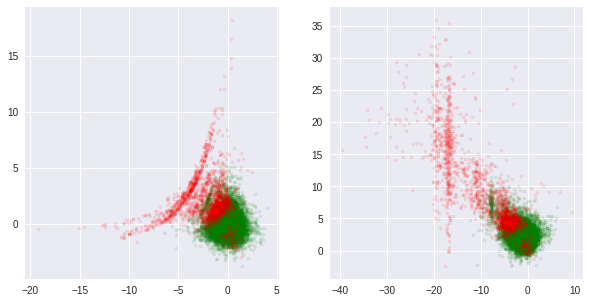

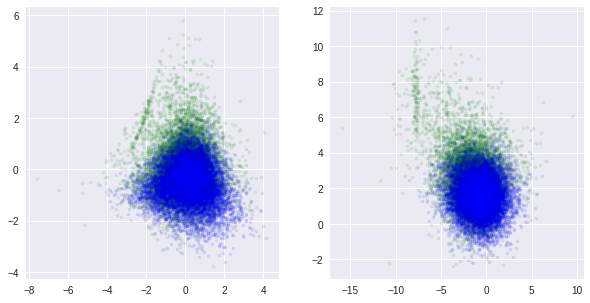

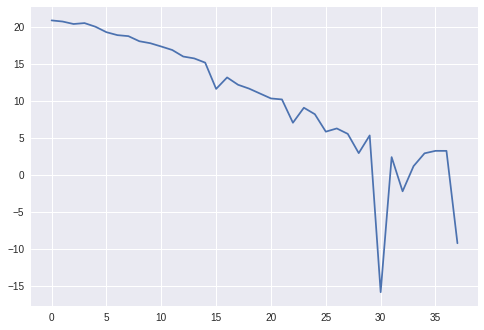

model 1 epoch 0
losss at 0 : 21.364868         elbo1: 2.4554837   elbo2: 20.850544   elbo3: -1.9411612
losss at 200 : 20.992798         elbo1: 2.6751502   elbo2: 20.482695   elbo3: -2.1650476
losss at 400 : 21.549568         elbo1: 3.2462332   elbo2: 20.399433   elbo3: -2.0961003
losss at 600 : 20.791597         elbo1: 3.0191925   elbo2: 20.095085   elbo3: -2.3226817
losss at 800 : 19.855965         elbo1: 2.680785   elbo2: 19.661493   elbo3: -2.4863138
losss at 1000 : 19.509815         elbo1: 2.6718664   elbo2: 19.19179   elbo3: -2.3538418
losss at 1200 : 19.052227         elbo1: 3.1035888   elbo2: 18.797556   elbo3: -2.8489196
losss at 1400 : 18.721712         elbo1: 2.8777738   elbo2: 18.519764   elbo3: -2.6758246
losss at 1600 : 18.549492         elbo1: 2.8836484   elbo2: 18.342684   elbo3: -2.676841
losss at 1800 : 17.79502         elbo1: 2.8406146   elbo2: 17.75423   elbo3: -2.7998261
losss at 2000 : 17.865097         elbo1: 2.951075   elbo2: 17.733685   elbo3: -2.8196628
losss a

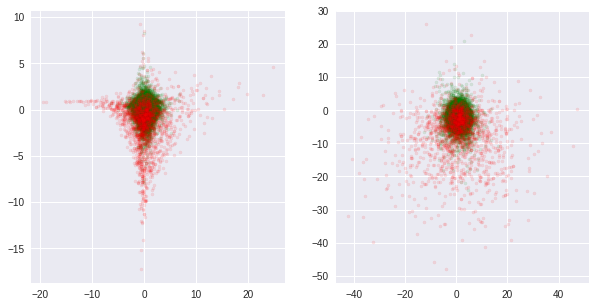

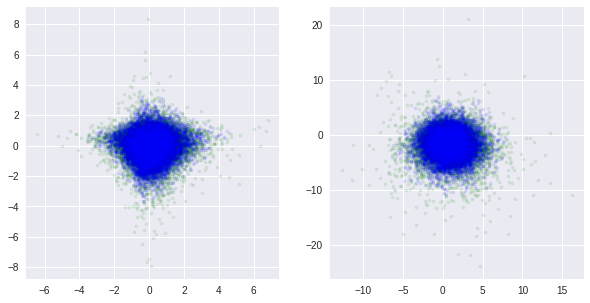

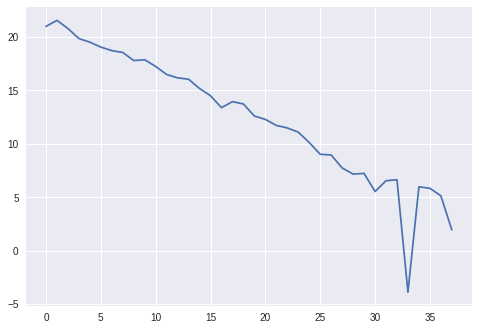

model 2 epoch 0
losss at 0 : 21.492273         elbo1: 2.672335   elbo2: 20.667532   elbo3: -1.8475919
losss at 200 : 25.032896         elbo1: 6.6581526   elbo2: 20.161676   elbo3: -1.7869345
losss at 400 : 20.7613         elbo1: 2.5552912   elbo2: 20.090466   elbo3: -1.8844565
losss at 600 : 20.55561         elbo1: 2.5937653   elbo2: 19.891943   elbo3: -1.9300996
losss at 800 : 20.378607         elbo1: 2.3522687   elbo2: 19.757847   elbo3: -1.731509
losss at 1000 : 20.190771         elbo1: 2.5396688   elbo2: 19.48665   elbo3: -1.835546
losss at 1200 : 19.794071         elbo1: 2.6980038   elbo2: 18.997723   elbo3: -1.901657
losss at 1400 : 19.417408         elbo1: 2.4092727   elbo2: 18.970272   elbo3: -1.9621388
losss at 1600 : 19.136635         elbo1: 2.3439271   elbo2: 18.850653   elbo3: -2.057947
losss at 1800 : 18.979618         elbo1: 2.5848017   elbo2: 18.294268   elbo3: -1.899451
losss at 2000 : 18.54103         elbo1: 2.6287496   elbo2: 17.872936   elbo3: -1.9606562
losss at 220

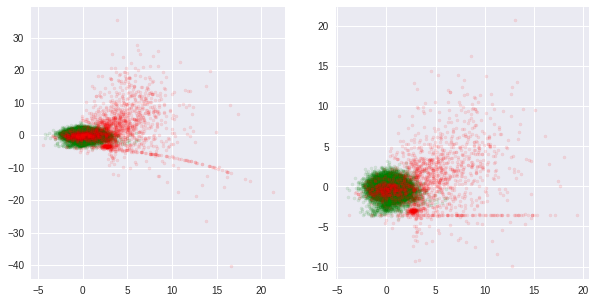

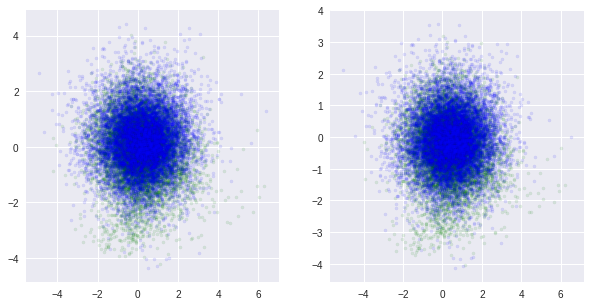

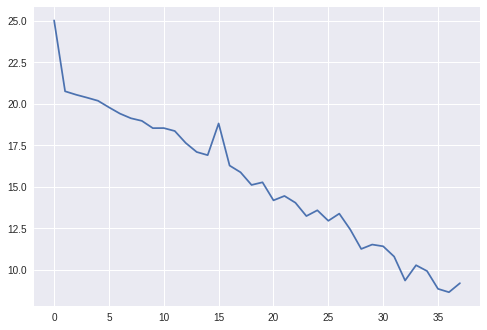

model 3 epoch 0
losss at 0 : 21.415308         elbo1: 2.732279   elbo2: 21.159225   elbo3: -2.4761965
losss at 200 : 21.183897         elbo1: 2.6206138   elbo2: 20.887705   elbo3: -2.3244212
losss at 400 : 20.958923         elbo1: 2.6825333   elbo2: 20.62822   elbo3: -2.3518293
losss at 600 : 20.72196         elbo1: 2.7284727   elbo2: 20.428354   elbo3: -2.4348679
losss at 800 : 20.31477         elbo1: 2.8557825   elbo2: 19.985668   elbo3: -2.526682
losss at 1000 : 20.049503         elbo1: 2.593637   elbo2: 19.87671   elbo3: -2.4208431
losss at 1200 : 19.741537         elbo1: 2.812871   elbo2: 19.533228   elbo3: -2.6045618
losss at 1400 : 19.39944         elbo1: 2.9156885   elbo2: 19.115763   elbo3: -2.6320124
losss at 1600 : 18.96532         elbo1: 2.8099976   elbo2: 18.780548   elbo3: -2.6252258
losss at 1800 : 19.046886         elbo1: 3.0197043   elbo2: 18.726181   elbo3: -2.6989987
losss at 2000 : 18.196182         elbo1: 3.118029   elbo2: 17.92121   elbo3: -2.8430572
losss at 2200

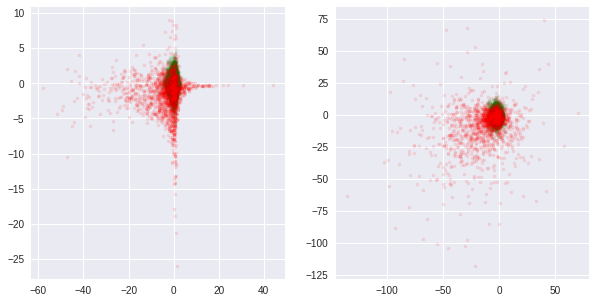

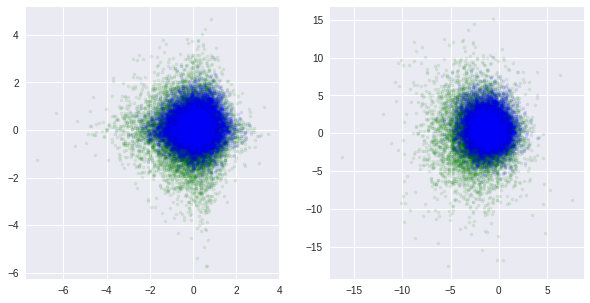

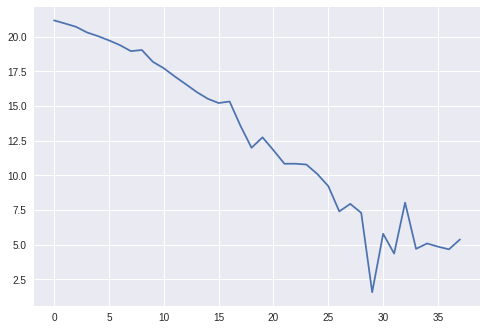

model 4 epoch 0
losss at 0 : 21.657156         elbo1: 2.3967803   elbo2: 21.028397   elbo3: -1.7680212
losss at 200 : 21.263056         elbo1: 2.1698186   elbo2: 20.686077   elbo3: -1.5928365
losss at 400 : 20.70705         elbo1: 2.3222907   elbo2: 20.338785   elbo3: -1.9540262
losss at 600 : 20.653881         elbo1: 2.264073   elbo2: 20.200863   elbo3: -1.8110547
losss at 800 : 20.283194         elbo1: 2.3085215   elbo2: 19.88177   elbo3: -1.907097
losss at 1000 : 19.87276         elbo1: 2.2546656   elbo2: 19.673515   elbo3: -2.0554197
losss at 1200 : 19.678778         elbo1: 2.2441828   elbo2: 19.446941   elbo3: -2.0123484
losss at 1400 : 19.328485         elbo1: 2.432253   elbo2: 19.118149   elbo3: -2.2219152
losss at 1600 : 19.135086         elbo1: 2.3817391   elbo2: 18.819767   elbo3: -2.0664182
losss at 1800 : 18.459179         elbo1: 2.6836731   elbo2: 18.082   elbo3: -2.3064947
losss at 2000 : 18.120144         elbo1: 2.5089207   elbo2: 17.89739   elbo3: -2.2861674
losss at 22

In [0]:
#Credit Card Fraud Detection
#Normal as green and Abnormal as red

#Bernoulli Decoder

num_models = 5
ensemble_results = []
adv_ensemble_results = []
adv_ensemble_results2 = []
test_ensemble_elbos = []
test_ensemble_elbos1 = []
#if elbo is above this, anomaly!
elbo_threshold = 0.2
test_ensemble_results = []


def make_enc_nn(x, out_size, hidden_size=(128,)):
    net = x
    for h in hidden_size:
        net = tf.layers.dense(inputs=net, units=h, activation=tf.nn.relu)
    return tf.layers.dense(inputs=net, units=out_size)
  
  
def make_arflow(z_dist, n_flows=6, hidden_size=(128,) * 2, invert=False):
    chain = list(itertools.chain.from_iterable([tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(hidden_size)),
                                                   tfb.Permute(np.random.permutation(2)), ] for _ in range(n_flows)))
    return tfd.TransformedDistribution(distribution=z_dist, bijector=tfb.Chain(chain[:-1]))


def make_dec_nn(x, out_size, hidden_size=(128,)):
    net = x
    for h in hidden_size:
        net = tf.layers.dense(inputs=net, units=h, activation=tf.nn.relu)
    return tf.layers.dense(inputs=net, units=out_size)
  
  
def make_decoder(z, x_shape=30):
    net = make_dec_nn(z, x_shape)
    return tfd.Independent(tfd.Bernoulli(logits=net))


def make_prior(z_size=2):
    return make_arflow(tfd.MultivariateNormalDiag(loc=tf.zeros([z_size], dtype=tf.float32), scale_diag = tf.ones([z_size], dtype=tf.float32)))


tf.reset_default_graph()
with tf.Graph().as_default() as g:
    input_layer = tf.placeholder(tf.float32, shape=[None, 30], name='x')
    output_layer = tf.placeholder(tf.float32, shape=[None, 30], name='y')
    latent = make_prior()
    
    
    with tf.variable_scope("encoder"):
        enc_mean, enc_std = make_encoder(input_layer)
    enc = tfd.MultivariateNormalDiag(loc=enc_mean, scale_diag=enc_std)
    enc_samples = enc.sample()
    
    
    
    posterior_samples = enc.sample(100)
    samples = [latent.bijector.inverse(posterior_samples)]
    samples.append(posterior_samples)

    
    '''
    # construct IAF flows
    samples = [my_samples]

    names = [enc.name]
    names = [latent.name]
    for bijector in reversed(latent.bijector.bijectors):
        my_samples = bijector.forward(my_samples)
        samples.append(my_samples)
        names.append(bijector.name)

    '''
    
    # reconstruct input
    with tf.variable_scope("decoder"):
      recons = make_decoder(enc_samples)

    recons_mean = recons.mean()
    recons_var = recons.variance()
   
  
    # elbo2  is reconstruction loss
    # elbo1+elbo3 is "kl divergence"
    
    elbo1_list = -latent.log_prob(enc_samples)
    elbo1 = tf.reduce_mean(elbo1_list)
    elbo2_list = -recons.log_prob(output_layer)
    elbo2 = tf.reduce_mean(elbo2_list)
    elbo3_list = enc.log_prob(enc_samples)
    elbo3 = tf.reduce_mean(elbo3_list)
    elbo_list = elbo1_list+elbo2_list+elbo3_list
    elbo = tf.reduce_mean(elbo_list)
   
    
    gradients = tf.gradients(elbo, input_layer)
    adv_examples = input_layer + 0.3*tf.sign(gradients)[0]
    
    
    random_noise = tfd.Uniform(low=0.0, high=1.0)
    random_noise_samples = random_noise.sample(sample_shape=(100,30))
    adv_examples2 = random_noise_samples - 0.3*tf.sign(gradients)[0]
    
    #adv_examples = input_layer 
    
    with tf.variable_scope("encoder", reuse=True):
      adv_enc_mean, adv_enc_std = make_encoder(adv_examples)
    with tf.variable_scope("encoder", reuse=True):  
      adv_enc_mean2, adv_enc_std2 = make_encoder(adv_examples2)
      
    adv_enc = tfd.MultivariateNormalDiag(loc=adv_enc_mean, scale_diag=adv_enc_std)
    adv_enc2 = tfd.MultivariateNormalDiag(loc=adv_enc_mean2, scale_diag=adv_enc_std2)

    adv_enc_samples = adv_enc.sample()
    adv_enc_samples2 = adv_enc2.sample()
    
    adv_posterior_samples = adv_enc.sample(100)
    adv_posterior_samples2 = adv_enc2.sample(100)
    adv_samples = [latent.bijector.inverse(adv_posterior_samples)]
    adv_samples2 = [latent.bijector.inverse(adv_posterior_samples2)]

    adv_samples.append(adv_posterior_samples)
    adv_samples2.append(adv_posterior_samples2)
    
    with tf.variable_scope("decoder", reuse=True):
      adv_recons = make_decoder(adv_enc_samples)
    with tf.variable_scope("decoder", reuse=True):
      adv_recons2 = make_decoder(adv_enc_samples2)

    adv_recons_mean = adv_recons.mean()
    adv_recons_mean2 = adv_recons2.mean()
    adv_recons_var = adv_recons.variance()
    adv_recons_var2 = adv_recons.variance()
    
    adv_elbo1_list = - latent.log_prob(adv_enc_samples)
    adv_elbo1 = tf.reduce_mean(adv_elbo1_list)
    adv_elbo2_list = - adv_recons.log_prob(output_layer)
    adv_elbo2 = tf.reduce_mean(adv_elbo2_list)
    adv_elbo3_list = adv_enc.log_prob(adv_enc_samples)
    adv_elbo3 = tf.reduce_mean(adv_elbo3_list)
    adv_elbo_list = adv_elbo1_list + adv_elbo2_list + adv_elbo3_list
    adv_elbo = adv_elbo1 + adv_elbo2 + adv_elbo3
    
    adv_elbo1_list2 = - latent.log_prob(adv_enc_samples2)
    adv_elbo12 = tf.reduce_mean(adv_elbo1_list2)
    adv_elbo2_list2 = - adv_recons2.log_prob(output_layer)
    adv_elbo22 = tf.reduce_mean(adv_elbo2_list2)
    adv_elbo3_list2 = adv_enc2.log_prob(adv_enc_samples2)
    adv_elbo32 = tf.reduce_mean(adv_elbo3_list2)
    adv_elbo_list2 = adv_elbo1_list2 + adv_elbo2_list2 + adv_elbo3_list2
    adv_elbo2 = adv_elbo12 + adv_elbo22 + adv_elbo32
   
    # print(tf.global_variables())
    # print(g.get_operations())
    # reconstruct input
    
    #flows_variables = tf.global_variables(scope="masked_autoregressive_default_template")
    #decoder_variables = tf.global_variables(scope="decoder")

    optimizer = tf.train.AdamOptimizer(0.00001)
    train_op = optimizer.minimize(elbo)
    #f_train_op = optimizer.minimize(elbo, var_list=flows_variables+decoder_variables)

    tf.summary.scalar('elbo1', elbo1)
    tf.summary.scalar('elbo2', elbo2)
    tf.summary.scalar('elbo3', elbo3)
    tf.summary.scalar('elbo', elbo)
    
    summ_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./logs/train')
    saver = tf.train.Saver()
    init = tf.global_variables_initializer()
    g.finalize()

# train and visualize
with tf.Session(graph=g) as sess:

    train_writer.add_graph(g)
    
    for model in range(5):
        step = 0
        losses = []
        losses_1 = []
        losses_2 = []
        losses_3 = []
        global_step = []
        sess.run(init)
        
        for epoch in range(3):
        
            np.random.shuffle(normal_data)
            np.random.shuffle(anormal_X)
            print("model",str(model),"epoch",str(epoch))
            
   
            for batch_x in get_batch(normal_data, 100):
                # train
                feed_dict = {input_layer: batch_x, output_layer:batch_x}
                #if step <= 5000:
                fetch_dict = {'loss': elbo, 'elbo1':elbo1, 'elbo2':elbo2, 'elbo3':elbo3, 'train': train_op, 'summary': summ_op}
                #else:
                #  fetch_dict = {'loss': elbo, 'elbo1':elbo1, 'elbo2':elbo2, 'elbo3':elbo3, 'train': f_train_op, 'summary': summ_op}

                result = sess.run(fetch_dict, feed_dict)
                # collect loss
                if step % 200 == 0:
                    train_writer.add_summary(result['summary'], step)
                    global_step.append(step)
                    losses.append(result['loss'])
                    print("losss at", step, ":", result['loss'], "        elbo1:", result["elbo1"],"  elbo2:", result["elbo2"], "  elbo3:",result["elbo3"])
                
                step += 1
            
            # visualize

        feed_dict = {input_layer: batch_x, output_layer:batch_x}
        fetch_dict = {'recons_mean':recons_mean, 'recons_var':recons_var,'samples':samples,  'adv_recons_mean':adv_recons_mean,
                      'adv_recons_var':adv_recons_var,'adv_elbo_list':adv_elbo_list,'adv_elbo1_list':adv_elbo1_list,
                      'adv_elbo2_list':adv_elbo2_list,'adv_elbo3_list':adv_elbo3_list,'elbo_list':elbo_list,
                      'elbo1_list':elbo1_list,'elbo2_list':elbo2_list,'elbo3_list':elbo3_list,'adv_samples2':adv_samples2,
             'adv_examples':adv_examples, 'adv_examples2':adv_examples2, 'adv_recons_mean2':adv_recons_mean2, 
                      'adv_recons_var2':adv_recons_var2,'adv_elbo1_list2':adv_elbo1_list2,
                      'adv_elbo2_list2':adv_elbo2_list2,'adv_elbo3_list2':adv_elbo3_list2, 'adv_elbo_list2':adv_elbo_list2}

        results = sess.run(fetch_dict, feed_dict)

        #run anomalies
        feed_dict = {input_layer: anormal_data}
        fetch_dict = {'samples':samples}
        anom_results = sess.run(fetch_dict,feed_dict)
        sample_results = results["samples"]
        adv_sample_results = results["adv_samples2"]


        anom_sample_results = anom_results["samples"]
        f, arr = plt.subplots(1, len(sample_results), figsize=(10, 5))
        # select samples from one data point
        # print mean and variance of z0 from multivar

        # visualize how the samples change
        for i in range(len(sample_results)):
            X1 = sample_results[i]
            anom = anom_sample_results[i]
            arr[i].scatter(X1[:, :, 0], X1[:, :, 1], s=10, color='green', alpha=0.1)
            arr[i].scatter(anom[:, :20, 0], anom[:, :20, 1], s=10, color='red', alpha=0.1)

        plt.show()

        f, arr = plt.subplots(1, len(sample_results), figsize=(10, 5))


        # visualize how adversarial examples change   
        for i in range(len(sample_results)):
            X1 = sample_results[i]
            adv_X1 = adv_sample_results[i]
            arr[i].scatter(X1[:, :, 0], X1[:, :, 1], s=10, color='green', alpha=0.1)
            arr[i].scatter(adv_X1[:, :, 0], adv_X1[:, :, 1], s=10, color='blue', alpha=0.1)

        plt.show()

        plt.plot(losses[1:])
        plt.show()

        ensemble_results.append((results["recons_mean"],results["recons_var"]))
        adv_ensemble_results.append((results["adv_recons_mean"], results["adv_recons_var"]))
        adv_ensemble_results2.append((results["adv_recons_mean2"], results["adv_recons_var2"]))

        # check variance of ensemble model
        feed_dict = {input_layer: test_data[:,:-1], output_layer:test_data[:,:-1]}
        fetch_dict = {'recons_mean':recons_mean, 'recons_var':recons_var, 'elbo_list':elbo_list,
                              'elbo1_list':elbo1_list,'elbo2_list':elbo2_list,'elbo3_list':elbo3_list}
        test_results = sess.run(fetch_dict, feed_dict)
        test_ensemble_elbos.append(test_results["elbo_list"])
        test_ensemble_elbos1.append(test_results["elbo1_list"])
        test_ensemble_results.append((test_results['recons_mean'],test_results['recons_var']))
        
          
    ensemble_mean, ensemble_var = ensemble_mean_var(ensemble_results)
    adv_ensemble_mean, adv_ensemble_var = ensemble_mean_var(adv_ensemble_results)
    adv_ensemble_mean2, adv_ensemble_var2 = ensemble_mean_var(adv_ensemble_results2)
    test_elbo_var = np.var(test_ensemble_elbos, axis=0)
    test_elbo_mean = np.mean(test_ensemble_elbos, axis=0)
    test_elbo1_mean = np.mean(test_ensemble_elbos1,axis=0)
    test_elbo1_var = np.var(test_ensemble_elbo1, axis=0)
    test_mean, test_var = ensemble_mean_var(test_ensemble_results)
    
    var_threshold = np.arange(130,200,2)
    
    #predictions1
    for threshold in var_threshold:
      print("Var Threshold: ",str(threshold))
      predictions1 = np.zeros(test_data.shape[0])
      predictions1[np.argwhere(test_elbo_var>threshold)] = 1


      ap_score = average_precision_score(y_true=test_data[:,-1], y_score=predictions1)
      auroc_score = roc_auc_score(y_true=test_data[:,-1], y_score=predictions1)
      stats = statistics(test_data[:,-1],predictions1)
      print("TP:",str(stats[0])," FP:",str(stats[1])," TN:",str(stats[2])," FN:",str(stats[3]))
      print("average precision socre :",str(ap_score), "at iteration", str(step))
      print("auroc score is : ",str(auroc_score), "at iteration",str(step))
    
   
    
    elbo1_mean_threshold = np.arange(8,12,0.5)
    
    #predictions2
    for threshold in elbo1_mean_threshold:
      print("Elbo1 Threshold: ",str(threshold))
      predictions3 = np.zeros(test_data.shape[0])
      predictions3[np.argwhere(test_elbo1_mean>threshold)] = 1


      ap_score = average_precision_score(y_true=test_data[:,-1], y_score=predictions3)
      auroc_score = roc_auc_score(y_true=test_data[:,-1], y_score=predictions3)
      stats = statistics(test_data[:,-1],predictions3)
      print("TP:",str(stats[0])," FP:",str(stats[1])," TN:",str(stats[2])," FN:",str(stats[3]))
      print("average precision socre :",str(ap_score), "at iteration", str(step))
      print("auroc score is : ",str(auroc_score), "at iteration",str(step))
    
    
    elbo1_var_threshold = np.arange(0,10,1)
    
    #predictions2
    for threshold in elbo1_var_threshold:
      print("Elbo1 Threshold: ",str(threshold))
      predictions3 = np.zeros(test_data.shape[0])
      predictions3[np.argwhere(test_elbo1_var>threshold)] = 1


      ap_score = average_precision_score(y_true=test_data[:,-1], y_score=predictions3)
      auroc_score = roc_auc_score(y_true=test_data[:,-1], y_score=predictions3)
      stats = statistics(test_data[:,-1],predictions3)
      print("TP:",str(stats[0])," FP:",str(stats[1])," TN:",str(stats[2])," FN:",str(stats[3]))
      print("average precision socre :",str(ap_score), "at iteration", str(step))
      print("auroc score is : ",str(auroc_score), "at iteration",str(step))
    
    f, arr = plt.subplots(4, len(sample_results), figsize=(10, 10))
    
    arr[0,0].hist(results['recons_var'])
    arr[0,1].hist(ensemble_var)
    arr[1,0].hist(results['adv_recons_var'])
    arr[1,1].hist(adv_ensemble_var)
    arr[2,0].hist(results['adv_recons_var2'])
    arr[2,1].hist(adv_ensemble_var2)
    arr[3,0].hist(results['elbo_list'])
    arr[3,1].hist(results['adv_elbo_list2'])
    plt.show()
    
    
    

    
    
    
    saver.save(sess, './logs/ckpt/model-%d.ckpt' % (epoch))

